# H-Cz CNOT Quantum Gate
    (Neutral Atom Quantum Gate Noisy Simulation)

> _Devesh Kumar          
> MSc Physics         
> IIT Roorkee_
  

## The C-NOT Gate

This is a conditional gate that performs an X-gate (state flip) on the second qubit (target), if the state of the first qubit (control) is |1⟩.

Symbol of the C-NOT gate:
   
   <img src = 'cnot.png' height = 150 width = 150 align = 'center'></img>

The unitary matrix operator of C-NOT gate:
$$
U_{Ideal}=
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
\end{bmatrix}
$$

In [8]:
#Some imports from Pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

#Other imports 
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product

### Defining Register

The Register defines the positions of the atoms and their names. Here we've two atoms seprated by a distance of $5\mu m$, named `Control` and `Target` for 'control' and 'target' respectively.

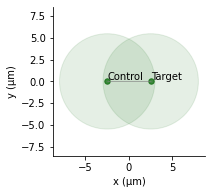


Blockade radius: 10.951586037372621


In [26]:
qubits = {'Control': (-2.5,0) , 'Target': (2.5,0) }

blockade_radius = Chadoq2.rydberg_blockade_radius(np.pi)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)

print(f'\nBlockade radius: {blockade_radius}')

### State prepration

This part of sequence corresponds to preparing the different states on which the CNOT gate will act. For this, we define the following Pulse instances

In [27]:
#function that takes the label string of a state and turns it into a ket state

def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

In [14]:
#Defining pulses
half_pi_wf = BlackmanWaveform(100, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)#, post_phase_shift=np.pi)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)#, post_phase_shift=np.pi)

pi_wf = BlackmanWaveform(300, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)


twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)

Sequence for state prepration:

In [15]:
def prep_seq(sid, reg):
    global seq
    
    seq = Sequence(reg, Chadoq2)

    #Declare channel
    seq.declare_channel('raman', 'raman_local')
    seq.declare_channel('ryd', 'rydberg_local', 'Control')
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq_dict = {'1':'Target', '0':'Control'}
    
    if sid == 'gg':
        basis = 'all'
        seq.target('Target','raman')
    else:
        basis = 'all'
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
            
    prep_state = state_prep(sid, basis)
            
    return prep_state

### Gate sequence

To realize the CNOT gate we apply H gate ($\pi/2$ pulse) before and after the common Cz sequence $\pi-2\pi-\pi$. This five pulse sequence is defined below. 


In [16]:
def CNOT_seq(int_id):

    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #CNOT sequence:
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse, 'raman', 'wait-for-all')# Wait for state preparation.
    seq.align('raman', 'ryd')
    
    seq.add(pi_pulse, 'ryd')
    seq.target('Target', 'ryd')    # Changes to target qubit
    seq.add(twopi_pulse, 'ryd')
    seq.target('Control', 'ryd')     # Changes back to control qubit
    seq.add(pi_pulse, 'ryd')
    
    seq.align('raman', 'ryd')
    seq.target('Target', 'raman')
    seq.add(half_pi_pulse_d, 'raman')
    
    return prep_state, prep_time

### Visualising sequence



 Visualization for the initial state '10': 




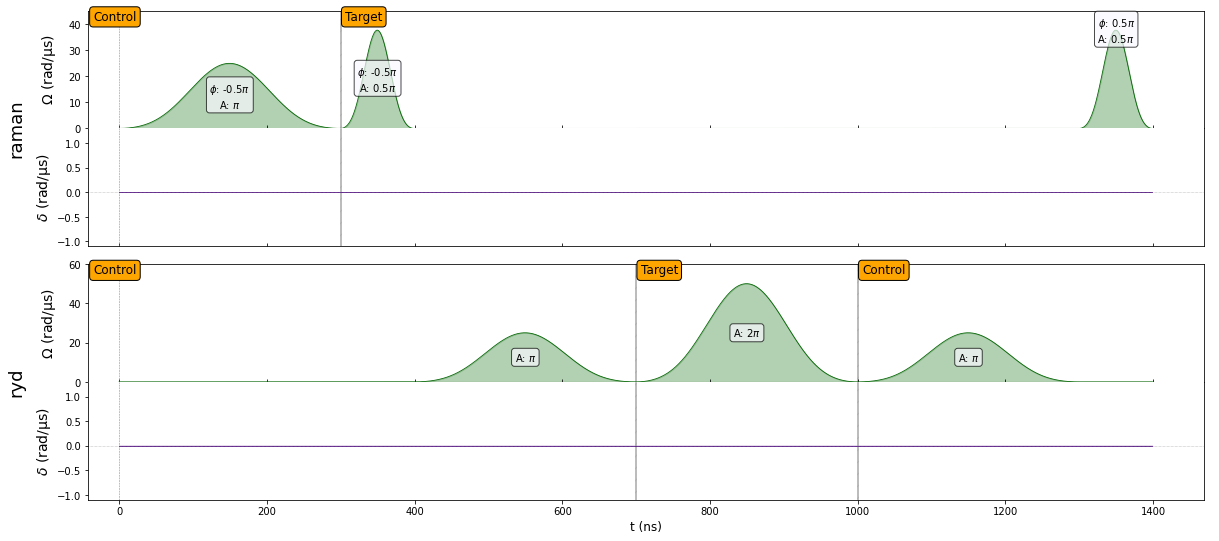


 Prepared state --> Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

 Preparation time: 300ns 


Channel: raman
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->300 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=4.71) | Targets: Control
t: 300->300 | Target: Target | Phase Reference: 0.0
t: 300->400 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=4.71) | Targets: Target
t: 400->1300 | Delay 
t: 1300->1400 | Pulse(Amp=Blackman(Area: 1.57), Detuning=0 rad/µs, Phase=1.57) | Targets: Target

Channel: ryd
t: 0 | Initial targets: Control | Phase Reference: 0.0 
t: 0->400 | Delay 
t: 400->700 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: Control
t: 700->700 | Target: Target | Phase Reference: 0.0
t: 700->1000 | Pulse(Amp=Blackman(Area: 6.28), Detuning=0 rad/µs, Phase=0) | Targets: Target
t: 1000->1000 | Target: Control | Phase Reference: 0.0
t:

In [17]:
print(f"\n\n Visualization for the initial state '10': \n\n")
prep_state, prep_time = CNOT_seq('eg')
seq.draw(draw_phase_area=True)
print(f'\n Prepared state --> {prep_state}')
print(f'\n Preparation time: {prep_time}ns \n\n')
print(seq)

### Simulating the CNOT sequence

Now we'll simulate the above defined sequence with some error introduced. There are following types of errors can be simulate in Pulser:
- SPAM (State Preparation And Measurement) errors : There are three types of such errors, one (with probability $\eta$) related to bad initial state preparation of the all-ground state $|g\rangle^{\otimes n}$, and two (with probabilities $\epsilon, \epsilon'$ ) linked to detection errors. During the imaging process, excited Rydberg atoms in $|r\rangle$ might decay to the state $|g\rangle$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $|g\rangle$ might get excited due to various causes (collisions…) and tweezer recapture might fail, inferring them incorrectly as atoms in $|r\rangle$ : those are the false positives modeled by $\epsilon$.

- Doppler damping : The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population. the standard deviation of the doppler noise, which is $k \times \sqrt{k_b T/M}$, where $k$ is the norm of the effective wavevector of the lasers.  

###### Ref: https://pulser.readthedocs.io/en/latest/tutorials/noisy_sim.html


Here `eta` is the probability of a badly prepared state, `epsilon` the false positive probability (excitation due collisions), `epsilon_prime` the false negative one (decay of rydberg atom to ground state).


For our consideration, the value of `eta: 0.02`, `epsilon: 0.01`, `epsilon_prime: 0.05` and the temperature: $ 100\mu K$.

1) ee 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]] Prep time: 600
 conts: Counter({'10': 9187, '00': 651, '11': 111, '01': 51})



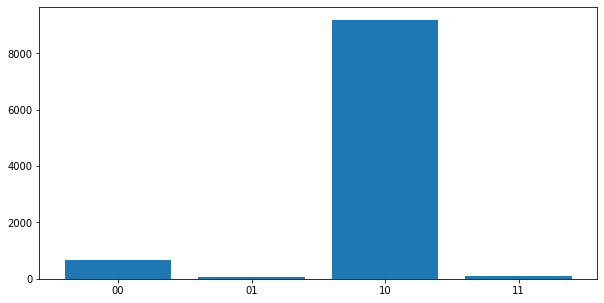

2) gg 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]] Prep time: 0
 conts: Counter({'00': 9419, '01': 444, '10': 130, '11': 7})



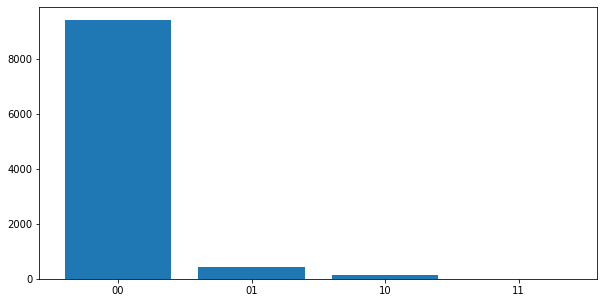

3) ge 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]] Prep time: 300
 conts: Counter({'01': 8899, '00': 977, '11': 111, '10': 13})



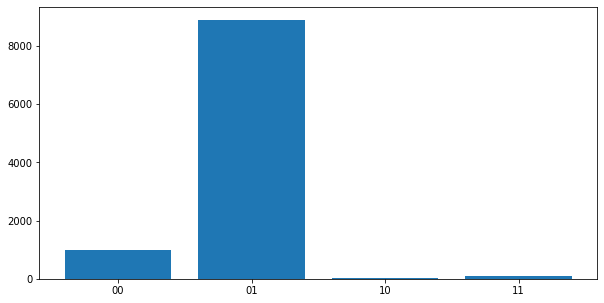

4) eg 
 Prep state:Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]] Prep time: 300
 conts: Counter({'11': 8648, '10': 657, '01': 633, '00': 62})



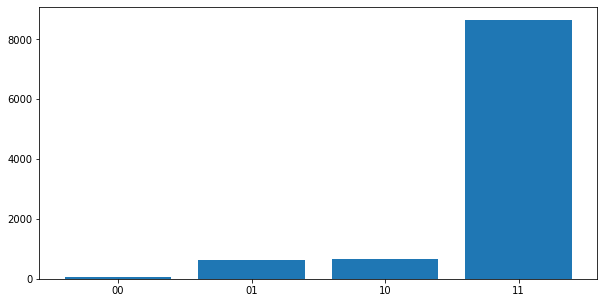

In [21]:
n=1
for sid in {'gg','ge','eg','ee'}:
    # Get CZ sequence
    prep_state, prep_time = CNOT_seq(sid) # constructs seq, prep_state and prep_time
    
    # Construct Simulation instance
    sim = Simulation(seq)
    cfg = SimConfig(noise=('SPAM', 'doppler'), eta=0.02, temperature=100, runs=1000) 
    sim.set_config(cfg)

    res = sim.run()
    count = res.sample_final_state(N_samples=1e4)
    
    print(f'{n}) {sid} \n Prep state:{prep_state} Prep time: {prep_time}\n conts: {count}\n')
    
    most_freq = {k:v for k,v in count.items() if v>5}
    
    plt.figure(figsize=(10,5))
    plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
    plt.xticks()#rotation ='vertical')
    plt.show()
    n +=1 


## Analysis


### Probability matrix

We get the probability matrix of Controlled-NOT (H-CZ CNOT) quantum gate using the graphs above, obtained from the simulation as follows


$$
U_{CNOT} =
\begin{bmatrix}
    0.9419 & 0.0444 & 0.0130 & 0.0007 \\
    0.0977 & 0.8899 & 0.0013 & 0.0111 \\
    0.0062 & 0.0633 & 0.0657 & 0.8648 \\
    0.0651 & 0.0057 & 0.9187 & 0.0111 \\
\end{bmatrix}
$$

### Fidelity

Fidelity$^*$ of the gate is given by,
$$
F = \frac{1}{4}tr[U_{Ideal}^{\dagger}U_{CNOT}]
$$

So,
$$
F = \frac{1}{4}tr
\begin{bmatrix}
    0.9419 & 0.0444 & 0.0130 & 0.0007 \\
    0.0977 & 0.8899 & 0.0013 & 0.0111 \\
    0.0651 & 0.0057 & 0.9187 & 0.0111 \\
    0.0062 & 0.0633 & 0.0657 & 0.8648 \\
\end{bmatrix}
$$

$$
F = \frac{1}{4} \big(0.9419+0.8899+0.9187+0.8648)
$$



Hence, the fidelity of the H-Cz CNOT gate is **$F = 0.9038$.**

###### $^*$ Ref: Demonstration of a Neutral Atom Controlled-NOT Quantum Gate (10.1103/PhysRevLett.104.010503)

